In [1]:
from collections import defaultdict

import numpy as np

from envs import ForbiddenAreaCfg, RewardCfg, make_gridworld
from common.vis import Visualizer
from common.policy import Policy
from common.utils import get_return, get_episode


env = make_gridworld(
    forbidden_area_cfg=ForbiddenAreaCfg(
        locs=[[1, 1], [1, 2], [2, 2], [3, 1], [3, 3], [4, 1]]
    ),
    reward_cfg=RewardCfg(forbidden_area=-10, out_of_bound=-1, move=0, target=1),
    start_loc=(0, 0),
    target_loc=(3, 2),
)

vis = Visualizer(env)

# MC Basic

In [2]:
policy = Policy(env)
episode_length = 30
num_episodes = 1  # the policy does not change when collecting episodes
k = 10
gamma = 0.9

size = env.unwrapped.size
states = [(i, j) for i in range(size[0]) for j in range(size[1])]

In [3]:
for _ in range(k):
    for s in states:
        q_values = np.empty(5)
        for a in range(5):  # 0: up, 1: right, 2: down, 3: left, 4: stay
            # get enough return to estimate the expected q value
            q = np.array(
                [
                    get_return(s, a, env, policy, episode_length, gamma)
                    for _ in range(num_episodes)
                ]
            )
            q_values[a] = q.mean(dtype=np.float32)
        policy.improve(s, q_values)

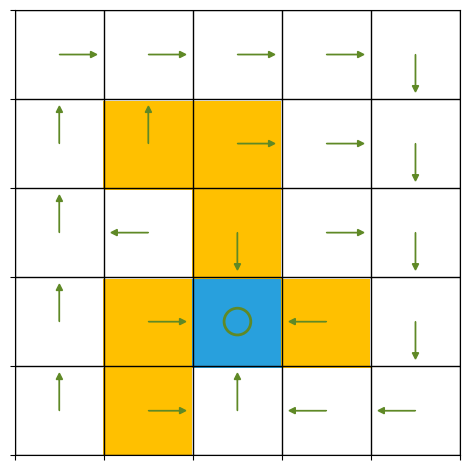

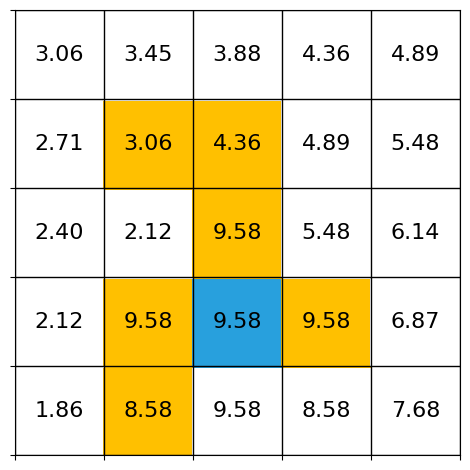

In [4]:
vis.draw_strategy(policy)
vis.draw_state_values(
    policy, episode_length=episode_length, num_episodes=num_episodes, gamma=gamma
)

# MC Exploring Starts

In [5]:
size = env.unwrapped.size
policy = Policy(env)
episode_length = 30
num_episodes = 100
gamma = 0.9

states = [(i, j) for i in range(size[0]) for j in range(size[1])]

In [6]:
sapairs = [(state, action) for state in states for action in range(5)]

Q = np.full((size[0], size[1], 5), np.finfo(np.float32).min, dtype=np.float32)
returns = defaultdict(float)
num_returns = defaultdict(int)

for _ in range(num_episodes):
    starting_pair = None
    num_selected = 0
    # search for a starting state-action pair and ensure that all pairs can be possibly selected.
    # NB: in actual implementation, there will not be a perfect starting pair can select all pairs.
    # in this case, we can not select all pairs within one episode, because the grid world envrionment is deterministic.
    for s, a in sapairs:
        selected_set = set()
        for sar in get_episode(s, a, env, policy, size[0] * size[1]):  # scan all states
            s_, a = sar.state, sar.action
            s = tuple(s_)
            selected_set.add((s, a))
        if len(selected_set) > num_selected:
            num_selected = len(selected_set)
            starting_pair = (s, a)

    episode = get_episode(
        starting_pair[0], starting_pair[1], env, policy, episode_length
    )
    episode.reverse()

    g = 0.0
    for sar in episode:
        s_, a, r = sar.state, sar.action, sar.reward
        s = tuple(s_)
        key = (s, a)

        g = gamma * g + r
        returns[key] += g
        num_returns[key] += 1

        # Policy Evaluation
        Q[s][a] = returns[key] / num_returns[key]
        # Policy Improvement
        policy.improve(s, Q[s])

We do not visuialize the strategy map and the state valuesw map for this case.  
The reason is that we can't guarantee the prerequisites of the MC Exploring Starts method, so the effect is very poor.

# MC $\epsilon$-Greedy

In [7]:
size = env.unwrapped.size
policy = Policy(env, eps=0.5)
episode_length = 10_000  # for full exploration
num_episodes = 100
gamma = 0.9

states = [(i, j) for i in range(size[0]) for j in range(size[1])]

In [8]:
Q = np.full((size[0], size[1], 5), np.finfo(np.float32).min, dtype=np.float32)
returns = defaultdict(float)
num_returns = defaultdict(int)

for _ in range(num_episodes):
    starting_state = states[np.random.randint(len(states))]
    starting_action = np.random.randint(5)

    episode = get_episode(starting_state, starting_action, env, policy, episode_length)
    episode.reverse()

    g = 0.0
    for sar in episode:
        s_, a, r = sar.state, sar.action, sar.reward
        s = tuple(s_)
        key = (s, a)

        g = gamma * g + r
        returns[key] += g
        num_returns[key] += 1

        # Policy Evaluation
        Q[s][a] = returns[key] / num_returns[key]
        # Policy Improvement
        policy.improve(s, Q[s])

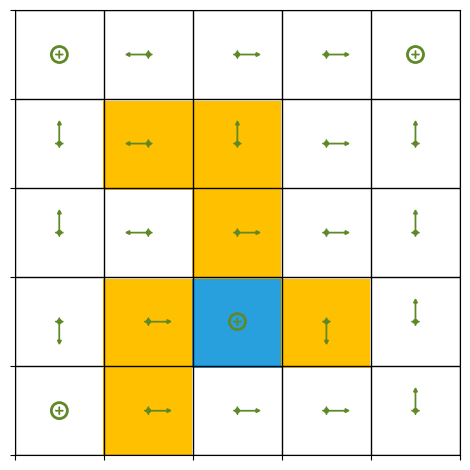

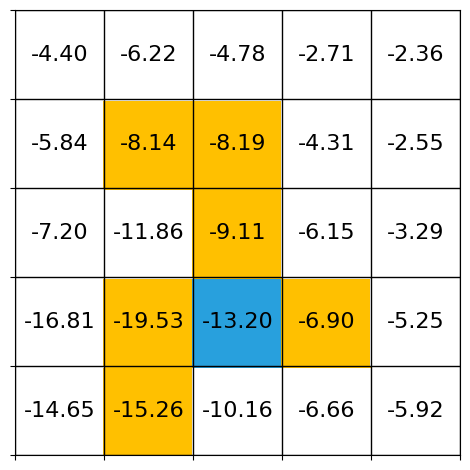

In [9]:
vis.draw_strategy(policy)
vis.draw_state_values(policy, q_values=Q, gamma=gamma)